In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import bisect

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
#indexData = pd.read_csv('../data/data.out', sep='\t', header=None)
indexData = pd.read_csv('data.out', sep='\t', header=None)

In [3]:
header = ['Term', 'Li_Len', '1s_Qnt', '1rl_Avg', 'Liwo1_Len', 'C_Li_Len', 'C_Liwo1_Len', 'EWAH_bitmap_Bytes', 'Bitmap_1s']
indexData.columns = header

In [4]:
indexData['Bitmap_Bytes'] = indexData.Li_Len / 8 + 1
indexData['Li_Bytes'] = indexData.Li_Len * 4
indexData['Liwo1_Bytes'] = indexData.Liwo1_Len * 4
indexData['C_Li_Bytes'] = indexData.C_Li_Len * 4
indexData['C_Liwo1_Bytes'] = indexData.C_Liwo1_Len * 4

# SS_Ratio (Space Saving): 1 - (CompressedSize / UncompressedSize) #
indexData['SS_Ratio_Li'] = 1 - (indexData.C_Li_Bytes / indexData.Li_Bytes)
indexData['SS_Ratio_Liwo1'] = 1 - (indexData.C_Liwo1_Bytes / indexData.Liwo1_Bytes)

indexData['SS_Ratio_Hybrid_Un'] = 1 - (indexData.Liwo1_Bytes + indexData.Bitmap_Bytes) / indexData.Li_Bytes
indexData['SS_Ratio_Hybrid_Co'] = 1 - (indexData.C_Liwo1_Bytes + indexData.EWAH_bitmap_Bytes) / indexData.Li_Bytes

In [5]:
indexData[indexData.columns[1:]]
#indexData[['SS_Ratio_Li', 'SS_Ratio_Liwo1', 'SS_Ratio_Hybrid_Un', 'SS_Ratio_Hybrid_Co']]

,Li_Len,1s_Qnt,1rl_Avg,Liwo1_Len,C_Li_Len,C_Liwo1_Len,EWAH_bitmap_Bytes,Bitmap_1s,Bitmap_Bytes,Li_Bytes,Liwo1_Bytes,C_Li_Bytes,C_Liwo1_Bytes,SS_Ratio_Li,SS_Ratio_Liwo1,SS_Ratio_Hybrid_Un,SS_Ratio_Hybrid_Co
0,984654,93752,1.177,890902,172285,159533,119016,93752,123082.750,3938616,3563608,689140,638132,0.825,0.821,0.064,0.808
1,11367,9,1.000,11358,3847,3850,72,9,1421.875,45468,45432,15388,15400,0.662,0.661,-0.030,0.660
2,76412,625,1.023,75787,20284,20238,2788,625,9552.500,305648,303148,81136,80952,0.735,0.733,-0.023,0.726
3,7493,218,5.450,7275,2612,2587,76,218,937.625,29972,29100,10448,10348,0.651,0.644,-0.002,0.652
4,4883,4,1.000,4879,1962,1960,32,4,611.375,19532,19516,7848,7840,0.598,0.598,-0.030,0.597
5,3867,4,1.000,3863,1580,1593,32,4,484.375,15468,15452,6320,6372,0.591,0.588,-0.030,0.586
6,4494,8,1.000,4486,1730,1748,40,8,562.750,17976,17944,6920,6992,0.615,0.610,-0.030,0.609
7,4887,1,1.000,4886,1790,1799,8,1,611.875,19548,19544,7160,7196,0.634,0.632,-0.031,0.631
8,4089,123,3.237,3966,1667,1661,56,123,512.125,16356,15864,6668,6644,0.592,0.581,-0.001,0.590
9,4095,1,1.000,4094,1568,1559,8,1,512.875,16380,16376,6272,6236,0.617,0.619,-0.031,0.619


In [6]:
indexData[indexData.columns[9:]].describe()

,Bitmap_Bytes,Li_Bytes,Liwo1_Bytes,C_Li_Bytes,C_Liwo1_Bytes,SS_Ratio_Li,SS_Ratio_Liwo1,SS_Ratio_Hybrid_Un,SS_Ratio_Hybrid_Co
count,175076.000,175076.000,175076.000,175076.000,175076.000,175076.000,175076.000,175076.000,175076.000
mean,1624.087,51938.777,48184.257,12119.291,11667.434,0.582,0.572,-0.004,0.563
std,12398.991,396767.698,309611.087,58989.851,51958.633,0.140,0.165,0.067,0.180
min,1.250,8.000,4.000,8.000,8.000,-0.500,-1.000,-0.031,-1.000
25%,26.875,828.000,796.000,360.000,356.000,0.500,0.493,-0.029,0.483
50%,113.125,3588.000,3536.000,1468.000,1460.000,0.599,0.595,-0.025,0.592
75%,416.875,13308.000,13204.000,5028.000,5016.000,0.681,0.677,-0.010,0.675
max,1112541.375,35601292.000,12304772.000,2630420.000,1315868.000,0.926,0.912,0.966,0.985


In [35]:
bins = np.array((.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.), dtype=np.float64)
count_won_SS_Ratio_Hybrid_Co = np.zeros(10, dtype=np.float64)
count_lost_SS_Ratio_Hybrid_Co = np.zeros(10, dtype=np.float64)

#won_SS_SS_Ratio_Hybrid_Co = indexData[indexData['SS_Ratio_Hybrid_Co'] > indexData['SS_Ratio_Hybrid_Co']]['SS_Ratio_Hybrid_Co']
won_SS_Ratio_Hybrid_Co = np.array(indexData.query('SS_Ratio_Hybrid_Co > SS_Ratio_Li')['SS_Ratio_Hybrid_Co'])
lost_SS_Ratio_Hybrid_Co = np.array(indexData.query('SS_Ratio_Hybrid_Co <= SS_Ratio_Li')['SS_Ratio_Hybrid_Co'])

# Interval Type [) #
for SS_Ratio_Hybrid_Co in won_SS_Ratio_Hybrid_Co:
    count_won_SS_Ratio_Hybrid_Co[bisect.bisect_right(bins, SS_Ratio_Hybrid_Co)] += 1
for SS_Ratio_Hybrid_Co in lost_SS_Ratio_Hybrid_Co:
    # First interval includes NEGATIVE values #
    count_lost_SS_Ratio_Hybrid_Co[bisect.bisect_right(bins, SS_Ratio_Hybrid_Co)] += 1
    
# Slower! #
#for index, row in indexData.iterrows():
#    if (row.SS_Ratio_Hybrid_Co > row.SS_Ratio_Li):
#        count_won_SS_SS_Ratio_Hybrid_Co[bisect.bisect_right(bins, row.SS_Ratio_Hybrid_Co)] += 1
#    else: # row.SS_Ratio_Hybrid_Co <= row.SS_Ratio_Li] #
#        count_lost_SS_SS_Ratio_Hybrid_Co[bisect.bisect_right(bins, row.SS_Ratio_Hybrid_Co)] += 1

count_won_SS_Ratio_Hybrid_Co = (count_won_SS_Ratio_Hybrid_Co / indexData.shape[0]) * 100
count_lost_SS_Ratio_Hybrid_Co = (count_lost_SS_Ratio_Hybrid_Co / indexData.shape[0]) * 100

print 'Bin\t\tWon\t\tLost'
previousBin = 0.0
totalWon = 0.0
totalLost = 0.0
for won, lost, bi in zip(count_won_SS_Ratio_Hybrid_Co, count_lost_SS_Ratio_Hybrid_Co, bins):
    print '[%.1f, %.1f)\t%.2f\t\t%.2f' %(previousBin, bi, won, lost)
    previousBin = bi
    totalWon += won
    totalLost += lost
print 'Total\t\t%.2f\t\t%.2f' %(totalWon, totalLost)


Bin		Won		Lost
[0.0, 0.1)	0.00		1.81
[0.1, 0.2)	0.00		0.96
[0.2, 0.3)	0.00		1.51
[0.3, 0.4)	0.08		7.48
[0.4, 0.5)	0.82		14.90
[0.5, 0.6)	2.35		22.32
[0.6, 0.7)	2.67		26.22
[0.7, 0.8)	2.04		15.71
[0.8, 0.9)	0.31		0.74
[0.9, 1.0)	0.10		0.00
Total		8.36		91.64


In [27]:
count_won_SS_Ratio_Hybrid_Un = np.zeros(10, dtype=np.float64)
#count_lost_SS_Ratio_Hybrid_Un = np.zeros(10, dtype=np.float64)

won_SS_Ratio_Hybrid_Un = np.array(indexData.query('SS_Ratio_Hybrid_Un > 0')['SS_Ratio_Hybrid_Un'])
#lost_SS_SS_Ratio_Hybrid_Un = np.array(indexData.query('SS_Ratio_Hybrid_Un <= 0')['SS_Ratio_Hybrid_Un'])

# Interval Type [) #
for SS_Ratio_Hybrid_Un in won_SS_Ratio_Hybrid_Un:
    count_won_SS_Ratio_Hybrid_Un[bisect.bisect_right(bins, SS_Ratio_Hybrid_Un)] += 1
#for SS_Ratio_Hybrid_Co in lost_SS_SS_Ratio_Hybrid_Un:
#    count_lost_SS_SS_Ratio_Hybrid_Co[bisect.bisect_right(bins, SS_Ratio_Hybrid_Co)] += 1

count_won_SS_Ratio_Hybrid_Un = (count_won_SS_Ratio_Hybrid_Un / indexData.shape[0]) * 100
#count_lost_SS_SS_Ratio_Hybrid_Co = (count_lost_SS_SS_Ratio_Hybrid_Co / indexData.shape[0]) * 100

print 'Bin\t\tWon'
previousBin = 0.0
totalWon = 0.0
for won, bi in zip(count_won_SS_Ratio_Hybrid_Un, bins):
    print '[%.1f, %.1f)\t%.2f' %(previousBin, bi, won)
    previousBin = bi
    totalWon += won
print 'Total\t\t%.2f' %(totalWon)



Bin		Won
[0.0, 0.1)	14.13
[0.1, 0.2)	2.52
[0.2, 0.3)	0.99
[0.3, 0.4)	0.57
[0.4, 0.5)	0.22
[0.5, 0.6)	0.08
[0.6, 0.7)	0.06
[0.7, 0.8)	0.04
[0.8, 0.9)	0.02
[0.9, 1.0)	0.07
Total		18.70


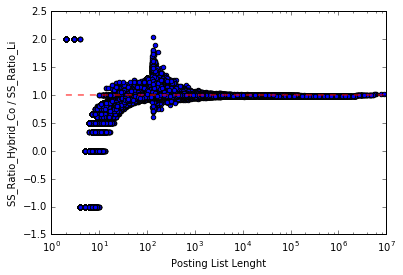

In [29]:
# SS_Ratio_Hybrid_Co / SS_Ratio_Li #

SS_Ratio_Hybrid_Co_over_SS_Ratio_Li = indexData.SS_Ratio_Hybrid_Co / indexData.SS_Ratio_Li

start = indexData.Li_Len.min()
stop = indexData.Li_Len.max()

s = np.arange(start, stop, 10, dtype=np.int64)
threshold = np.full((len(s)), 1.0, dtype=np.float64)

figure, ax = plt.subplots()
ax.plot(s, threshold, color='r', linestyle='--')
ax.scatter(indexData.Li_Len, SS_Ratio_Hybrid_Co_over_SS_Ratio_Li)

ax.set_xlabel('Posting List Lenght')
ax.set_ylabel('SS_Ratio_Hybrid_Co / SS_Ratio_Li')
ax.set_xscale('log')
#ax.set_yscale('log')

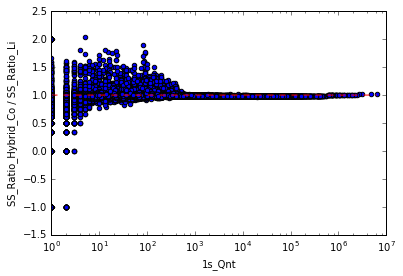

In [30]:
start = indexData['1s_Qnt'].min()
stop = indexData['1s_Qnt'].max()

s = np.arange(start, stop, 10, dtype=np.int64)
threshold = np.full((len(s)), 1.0, dtype=np.float64)

figure, ax = plt.subplots()
ax.plot(s, threshold, color='r', linestyle='--')
ax.scatter(indexData['1s_Qnt'], SS_Ratio_Hybrid_Co_over_SS_Ratio_Li)
ax.set_xlabel('1s_Qnt')
ax.set_ylabel('SS_Ratio_Hybrid_Co / SS_Ratio_Li')
ax.set_xscale('log')

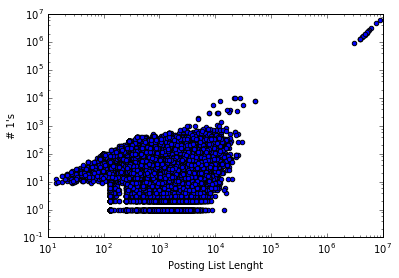

In [15]:
#compressCombinedClean = compressCombined[compressCombined['Li'] < 3.0]
combinedCoWin = compressCombined[compressCombined['Combined_Co'] < 1.0]

figure, ax = plt.subplots()
ax.scatter(combinedCoWin['Li'], combinedCoWin['1s'])
ax.set_xlabel('Posting List Lenght')
ax.set_ylabel('# 1\'s')
ax.set_xscale('log')
ax.set_yscale('log')

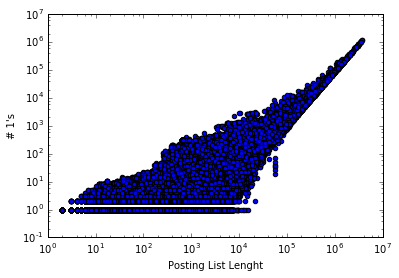

In [16]:
combinedCoLost = compressCombined[compressCombined['Combined_Co'] >= 1.0]

figure, ax = plt.subplots()
ax.scatter(combinedCoLost['Li'], combinedCoLost['1s'])
ax.set_xlabel('Posting List Lenght')
ax.set_ylabel('# 1\'s')
ax.set_xscale('log')
ax.set_yscale('log')

(0.0, 1.1)

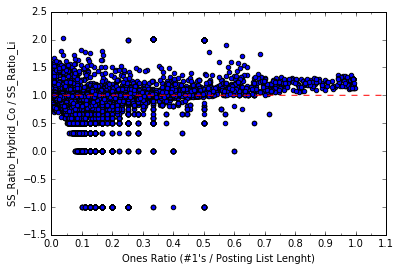

In [31]:
# How many ones do I need to win? #
# X-axis : One's proportion respect to Posting List Length #
# Y-axis : Hybrid Compression Ratio: HybridCompression / PForCompression #

start = 0.0
stop = 1.1

size = indexData.shape[0]

s = np.linspace(start, stop, size, dtype=np.float64)
threshold = np.full((len(s)), 1.0, dtype=np.float64)
onesRatio = indexData['1s_Qnt'] / indexData['Li_Len']

figure, ax = plt.subplots()
ax.scatter(onesRatio, SS_Ratio_Hybrid_Co_over_SS_Ratio_Li)
ax.plot(s, threshold, color='r', linestyle='--')
# Tickers #
min_x = MultipleLocator(0.05)
max_x = MultipleLocator(0.1)
ax.xaxis.set_major_locator(max_x)
ax.xaxis.set_minor_locator(min_x)
ax.set_xlabel('Ones Ratio (#1\'s / Posting List Lenght)')
ax.set_ylabel('SS_Ratio_Hybrid_Co / SS_Ratio_Li')
ax.set_xlim([0.0, 1.1])

In [21]:
bins = np.array((.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.), dtype=np.float64)
frequencyOnesRatioWon = np.zeros(10, dtype=np.float64)
frequencyOnesRatioLoet = np.zeros(10, dtype=np.float64)

win = compressCombined.query('Combined_Co <= 1.0')
lose = compressCombined.query('Combined_Co > 1.0') # Ties Included! #

onesRatioWin = np.array(win['1s'] / win['Li'])
onesRatioLose = np.array(lose['1s'] / lose['Li'])

# Interval Type [) #
for idx in xrange(0, onesRatioWin.shape[0]):
    frequencyOnesRatioWin[bisect.bisect_right(bins, onesRatioWin[idx])] += 1
for idx in xrange(0, onesRatioLose.shape[0]):
    frequencyOnesRatioLose[bisect.bisect_right(bins, onesRatioLose[idx])] += 1

frequencyOnesRatioWin = (frequencyOnesRatioWin / compressCombined['term'].count()) * 100
frequencyOnesRatioLose = (frequencyOnesRatioLose / compressCombined['term'].count()) * 100

print 'Ones Ratio\tGanamos\t\tPerdemos/Empatamos'
previousBin = 0.0
for un, co, bi in zip(frequencyOnesRatioWin, frequencyOnesRatioLose, bins):
    print '[%.1f, %.1f)\t%.2f\t\t%.2f' %(previousBin, bi, un, co)
    previousBin = bi

Ones Ratio	Ganamos		Perdemos/Empatamos
[0.0, 0.1)	8.09		84.40
[0.1, 0.2)	1.05		3.34
[0.2, 0.3)	0.58		1.01
[0.3, 0.4)	0.36		0.37
[0.4, 0.5)	0.19		0.08
[0.5, 0.6)	0.07		0.22
[0.6, 0.7)	0.07		0.01
[0.7, 0.8)	0.04		0.00
[0.8, 0.9)	0.03		0.00
[0.9, 1.0)	0.08		0.00


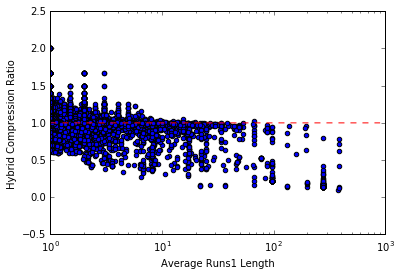

In [28]:
# What about 1's Runs? #
# X-axis : Average Run1 Length #
# Y-axis : Hybrid Compression Ratio: HybridCompression / PForCompression #

start = compressCombined['ar1l'].min()
stop = 900

size = compressCombined['term'].count()

s = np.linspace(start, stop, size, dtype=np.float32)
threshold = np.full((len(s)), 1.0, dtype=np.float16)

figure, ax = plt.subplots()
ax.plot(s, threshold, color='r', linestyle='--')
ax.scatter(compressCombined['ar1l'], compressCombined['Combined_Co'])
ax.set_xlabel('Average Runs1 Length')
ax.set_ylabel('Hybrid Compression Ratio')
ax.set_xscale('log')

In [35]:
bins = np.array((.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.), dtype=np.float64)
frequencyAR1LWin = np.zeros(10, dtype=np.float64)
frequencyAR1LLose = np.zeros(10, dtype=np.float64)

ar1lWin = np.array(compressCombined.query('Combined_Co < 1.0')['ar1l'])
ar1lLose = np.array(compressCombined.query('Combined_Co >= 1.0')['ar1l']) # Ties Included! #

# Interval Type [) #
for idx in xrange(0, ar1lWin.shape[0]):
    frequencyAR1LWin[bisect.bisect_right(bins, ar1lWin[idx])] += 1
for idx in xrange(0, ar1lLose.shape[0]):
    frequencyAR1LLose[bisect.bisect_right(bins, ar1lLose[idx])] += 1

frequencyAR1LWin = (frequencyAR1LWin / compressCombined['term'].count()) * 100
frequencyAR1LLose = (frequencyAR1LLose / compressCombined['term'].count()) * 100

print 'AR1L\tGanamos\t\tPerdemos/Empatamos'
previousBin = 0.0
for un, co, bi in zip(frequencyAR1LWin, frequencyAR1LLose, bins):
    print '[%.1f, %.1f)\t%.2f\t\t%.2f' %(previousBin, bi, un, co)
    previousBin = bi

IndexError: index 10 is out of bounds for axis 0 with size 10

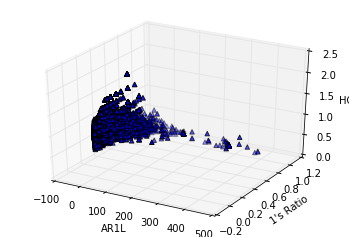

In [33]:
onesRatio = compressCombined['1s'] / compressCombined['Li']

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(compressCombined['ar1l'], onesRatio, compressCombined['Combined_Co'], marker='^')
ax.set_xlabel('AR1L')
ax.set_ylabel('1\'s Ratio')
ax.set_zlabel('HCR')

#ax.set_yscale('log')


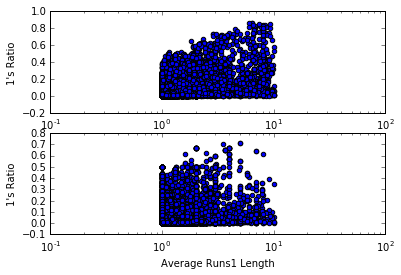

In [48]:
# AR1L : [10^0 - 10^1] #

win = compressCombined.query('(ar1l <= 10.0) & (Combined_Co < 1.0)')
loose = compressCombined.query('(ar1l <= 10.0) & (Combined_Co >= 1.0)')

onesRatioWin = win['1s'] / win['Li']
onesRatioLoose = loose['1s'] / loose['Li']

figure, ax = plt.subplots(2)
ax[0].scatter(win['ar1l'], onesRatioWin)
ax[0].set_xlabel('Average Runs1 Length')
ax[0].set_ylabel('1\'s Ratio')
ax[0].set_xscale('log')

ax[1].scatter(loose['ar1l'], onesRatioLoose)
ax[1].set_xlabel('Average Runs1 Length')
ax[1].set_ylabel('1\'s Ratio')
ax[1].set_xscale('log')

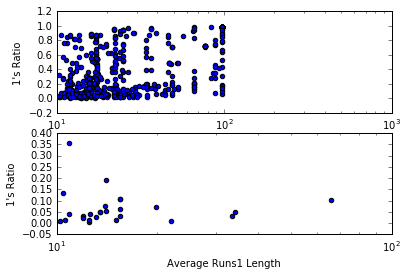

In [49]:
# AR1L : (10^1 - 10^2] #

win = compressCombined.query('(10.0 < ar1l <= 100.0) & (Combined_Co < 1.0)')
loose = compressCombined.query('(10.0 < ar1l <= 100.0) & (Combined_Co >= 1.0)')

onesRatioWin = win['1s'] / win['Li']
onesRatioLoose = loose['1s'] / loose['Li']

figure, ax = plt.subplots(2)
ax[0].scatter(win['ar1l'], onesRatioWin)
ax[0].set_xlabel('Average Runs1 Length')
ax[0].set_ylabel('1\'s Ratio')
ax[0].set_xscale('log')

ax[1].scatter(loose['ar1l'], onesRatioLoose)
ax[1].set_xlabel('Average Runs1 Length')
ax[1].set_ylabel('1\'s Ratio')
ax[1].set_xscale('log')

In [50]:
# AR1L : (10^2 - 10^3] #

win = compressCombined.query('(100.0 < ar1l <= 1000.0) & (Combined_Co < 1.0)')
loose = compressCombined.query('(100.0 < ar1l <= 1000.0) & (Combined_Co >= 1.0)')

onesRatioWin = win['1s'] / win['Li']
onesRatioLoose = loose['1s'] / loose['Li']

figure, ax = plt.subplots(2)
ax[0].scatter(win['ar1l'], onesRatioWin)
ax[0].set_xlabel('Average Runs1 Length')
ax[0].set_ylabel('1\'s Ratio')
ax[0].set_xscale('log')

ax[1].scatter(loose['ar1l'], onesRatioLoose)
ax[1].set_xlabel('Average Runs1 Length')
ax[1].set_ylabel('1\'s Ratio')
ax[1].set_xscale('log')


ValueError: Data has no positive values, and therefore can not be log-scaled.

ValueError: Data has no positive values, and therefore can not be log-scaled.

0.997435897436


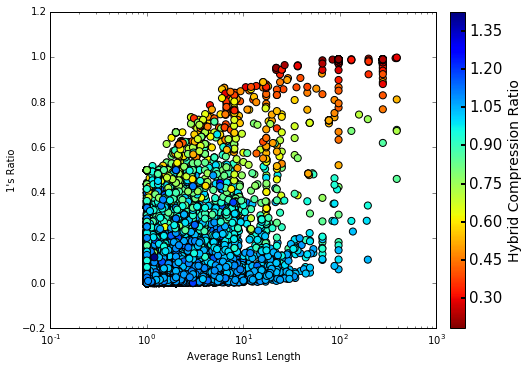

In [62]:
# http://eso-python.github.io/ESOPythonTutorials/ESOPythonDemoDay5_matplotlib_BerndHusemann_part2.html
#cmap=cm.RdBu_r
#cmap=cm.hsv_r
cmap=cm.jet_r
#figure, ax = plt.subplots(figsize=(7, 5))

plt.clf()
fig = plt.figure(figsize=(7,5))
ax = fig.add_axes([0.1,0.1,0.88,0.88])
scatter = ax.scatter(compressCombined['ar1l'], onesRatio, s=50, c=compressCombined['Combined_Co'], cmap=cmap)

cb = plt.colorbar(scatter, ax=ax, fraction=0.1, pad=0.03, aspect=20)
cb.ax.tick_params(width=2, labelsize=15)

cb.set_label('Hybrid Compression Ratio',fontsize=14)
ax.set_xlabel('Average Runs1 Length')
ax.set_ylabel('1\'s Ratio')

ax.set_xscale('log')